
<h1 style="font-size":40px>Portfolio Risk via Monte Carlo Simulations</h1>


<h2 style = "font-size:25px"><ins>THEORY</ins></h2> 

<p>Much of the mathematics discussed in the previous notebook for a single asset still applies when calculating the Value at Risk for a portfolio. Recall the SDE to model an asset: 
    
$$
d S = \mu S dt + \sigma S dW_t + S(J-1)dN
$$ 

To model a portfolio, we could write 
$$
d S_i = \mu S_i dt + \sigma S_i dW_i + S_i (J_i-1)dN_i
$$ 
instead, where $S_i (i=1,2,3....n)$ represents the price of the $i$th asset. The naïve approach to treat this system would be to solve each equation seperately, assuming that the Brownian and jump terms for each asset are independent random variables. However, asset prices are usually correlated so we need a way to couple the respective random variables if we are to model the portfolio realistically. 

<h3>Correlated Wiener Processes</h3>
To modify the Brownian fluctuations $dW_i$ to account for asset correlations, we first calculate the correlation matrix:

<a id="corr"></a>
$$
\begin{equation} \label{1}
C_{ij} = \text{Cor}(R_i,R_j)
\end{equation}
$$

where $R_i$ and $R_j$ represent the returns on the $i$th and $j$th assets respectively. Any matrix $C$ can be decomposed into a product of an lower-triangular matrix and and its conjugate transpose(the so-called Cholesky decomposition):
$$
C = L L^*
$$

Assuming that $C$ is a real matrix, we have

$$
L_{ij} =
\begin{cases}
\sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{j-1} L_{ik}^2}, & \text{if } i = j \\[10pt]
\frac{1}{L_{jj}} \left(\Sigma_{ij} - \sum\limits_{k=1}^{j-1} L_{ik} L_{jk} \right), & \text{if } i > j \\[10pt]
0, & \text{if } i < j
\end{cases}
$$

For a portfolio of $n$ assets, if $d\boldsymbol{W} = (dW_1,dW_2,.....dW_n)$ represents a vector of independent random normal variables, its dot product with $L$ provides a vector of correlated normal variables to model the individual Wiener processes with<a href="#ref1"><sup>[1]</sup></a>. In vector form, we have:

$$
d \boldsymbol{S} = \mu \boldsymbol{S} dt + \sigma \boldsymbol{S} L.d\boldsymbol{W} + \boldsymbol{S} (\boldsymbol{J}-1)d\boldsymbol{N}
$$
This is the standard way to simulate the continuous, fluctuating component of portfolio returns when the underlying assets are assumed to be correlated.
<h3>Correlated Jumps</h3>
There is no standard formalism for correlated jumps terms, but several methods of varying complexity exist. The simplest one consists of jumps perfectly correlated in magnitude and time across all assets. In this notebook, I apply the two-asset method described by Burgess<a href="#ref2"><sup>[2]</sup></a>, wherein each asset contains a term $J_i$ accounting for local shocks as well as a term $J_m$ that accounts for global shocks that affect all assets in the market. Extending this model to multiple assets:

<a id="eq-merton"></a>
$$
\begin{equation}
d \boldsymbol{S} = \mu \boldsymbol{S} dt + \sigma \boldsymbol{S} L.d\boldsymbol{W} + [\boldsymbol{S} [\boldsymbol{J}-1)d\boldsymbol{N} + (J_c-1) dN_c]\tag{1}
\end{equation}
$$
Note that the individual jump terms are constructed from independent random variables, but the common term $(J_c-1) dN_c$ ensures a non-zero correlation amongst asset shocks.


<h2 style= "font-size":30px><ins>CODE</ins></h2>
To implement this model on Python, we first import a few modules. 

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import factorial
import time
import multiprocessing as mp
import seaborn as sns
import datetime 

<h3>Parameter Estimation</h3>

We re-use the class from the previous notebook, to estimate the parameters $(\mu,\sigma,\mu_J,\sigma_J,\lambda)$ by minimizing the negative log of the likelihood function $-\ln[L(\theta;Y)]$.

In [2]:
class JD_Param_Est:
    """
    A class to estimate parameters for the Merton Jump-Diffusion model
    using historical stock price data.
    """

    #dictionary for later extensions to other PDFs
    PDF_METHOD_NAMES = {"normal": "PDF_normal",}

    def __init__(self,log_returns, Δt=1/252, pdf_type="normal"):
        """
        Initializes class variables: ticker, date range, time step, PDF for MLE
        """
        self.Δt = Δt
        self.log_returns = log_returns
        self.estimated_params = None
        if pdf_type not in self.PDF_METHOD_NAMES:
            raise ValueError(f"Unknown PDF type: '{pdf_type}'. Available types are: {list(self.PDF_METHOD_NAMES.keys())}")
        
        self.PDF_method = self.PDF_METHOD_NAMES[pdf_type] 


    def PDF_normal(self, X_t_i, k, μ, σ, μ_J, σ_J, λ, Δt):
        """
        PDF for normally distributed jumpts
        """
        #Poisson probability for k jumps
        p_Poisson = (np.exp(-λ * Δt) * (λ * Δt)**k / factorial(k))

        K = np.exp(μ_J + 0.5 * σ_J**2) - 1

        drift = (μ - λ * K - σ**2 / 2) * Δt + k * μ_J
        total_variance = σ**2 * Δt + k * σ_J**2

        
        if total_variance <= 1e-12:
            return 1e-300 #return tiny positive number to avoid errors

        #Normal probability density function for the log-return
        normal_pdf_component = (1 / np.sqrt(2 * np.pi * total_variance)) * \
                               np.exp(-(X_t_i - drift)**2 /
                                      (2 * total_variance))

        return p_Poisson * normal_pdf_component

    def Likelihood(self, params, X_t, Δt):
        """
        Calculates the negative log-likelihood for the PDF chosen in init.
        Input:
            params (tuple): A tuple of (μ, σ, μ_J, σ_J, λ).
            X_t (np.ndarray): Array of log returns.
            Δt (float): Time step.

        Output:
            float: The negative log-likelihood value.
        """
        μ, σ, μ_J, σ_J, λ = params

        n = len(X_t)
        num_jumps = 5
        f = np.zeros((n, num_jumps)) #maximum of 10 jumps 

        #get the selected PDF method for this instance
        jump_PDF = getattr(self, self.PDF_method)

        for i in range(n):
            for k in range(num_jumps):  
                f[i, k] = jump_PDF(X_t[i], k, μ, σ, μ_J, σ_J, λ, Δt)
            
        #sum over all k's
        R = np.sum(f, axis=1)

        #handle R=0 to avoid log(0) error
        R[R <= 0] = 1e-300

        LL = -np.sum(np.log(R))  #negative log-likelihood
        return LL

    def estimate_parameters(self, initial_guess=None, max_iter=5000):
        """
        Estimate the parameters of Jump-Diffusion model via MLE
        """
        print("\nParameter estimation in progress...")
        start_time = time.time()

        if initial_guess is None:
            initial_guess = np.array([1,1,1,1,1]) # μ, σ, μ_J, σ_J, λ
        
        #the means are unbounded, but σ, σ_J, and λ must be positive.
        bounds = [
            (-np.inf, np.inf), # μ
            (1e-6, np.inf),    # σ
            (-np.inf, np.inf), # μ_J
            (1e-6, np.inf),    # σ_J
            (1e-6, np.inf)     # λ
        ]

        estimation = minimize(self.Likelihood, initial_guess, args=(self.log_returns, self.Δt),
                              method='L-BFGS-B', bounds=bounds,
                              options={'disp': False, 'maxiter': max_iter})

        end_time = time.time()
        print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

        self.estimated_params = estimation.x
        return self.estimated_params

Next, we choose a list of stocks to construct a portfolio and estimate their respective $(\mu,\sigma,\mu_J,\sigma_J,\lambda)$.

In [3]:
tickers = ["MSFT","AMZN","AAPL","NVDA"]     #choose portfolio of stocks
Δt = 1/252
stop = datetime.date.today()
start = stop - datetime.timedelta(days=365)
est_params = {}
S0 = {} 
data = {}
for ticker in tickers:
    data = yf.download(ticker, start, stop, progress=False)
    prices = data['Close']
    log_returns = np.log(prices / prices.shift(1)).dropna()
    log_returns = log_returns[ticker].to_numpy()
    Model = JD_Param_Est(log_returns, Δt, pdf_type="normal")
    est_params[ticker] = Model.estimate_parameters()

#collect parameters
tuples = list(zip(*est_params.values()))
params = np.array([tup for tup in tuples])

YF.download() has changed argument auto_adjust default to True

Parameter estimation in progress...
Optimization finished in 1.16 seconds.

Parameter estimation in progress...
Optimization finished in 1.37 seconds.

Parameter estimation in progress...
Optimization finished in 1.30 seconds.

Parameter estimation in progress...
Optimization finished in 1.21 seconds.


We can use these values and the Monte Carlo class defined in a previous notebook in order to obtain the 30-day Value at Risk(VaR) and Expected Shortfall(ES) for the individual stocks over the considered time period($26/05/2024$ to $26/05/2025$ when this notebook was published). The results are tabulated below.

| Stock | μ | σ | μ_J | σ_J | λ | VaR (95.0%) | ES (95.0%) |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| MSFT | 0.086126 | 0.162477 | -0.004447 | 0.027873 | 48.680253 | -13.95% | -17.79% |
| NVDA | 0.315570 | 0.402965 | -0.014069 | 0.043890 | 85.565281 | -31.74% | -40.30% |
| AMZN | 0.160204 | 0.275374 | -0.002287 | 0.053345 | 15.655347 | -18.25% | -23.44% |
| AAPL | 0.082155 | 0.137421 | -0.006895 | 0.023923 | 129.886029 | -17.47% | -22.11% |

<h3>Correlation Matrix</h3>

The cell below calculates the correlation matrix C defined in <a href="#corr">(1)</a>, which is a prerequisite to performing Monte Carlo simulations.

In [4]:
#construct portfolio returns
weights = np.array([1/len(tickers) for i in range(len(tickers))]) #define weights
data = yf.download(tickers, start, stop)                          #download data
close_prices = data["Close"]
S0i = close_prices.iloc[0].to_numpy()                             #initial stock prices
returns = np.log(close_prices / close_prices.shift(1)).dropna()
portfolio_returns = np.dot(returns,weights)                       #portfolio of weighted stocks
C = returns.corr().values 

[*********************100%***********************]  4 of 4 completed


<h3>Monte Carlo Simulations</h3>
We modify the class defined in the previous notebook into the one below. It simulates the evolution of a collection of correlated stocks, given arrays of their respective parameters $\mu_i, \sigma_i, \lambda_i, \mu_{J_i}$ and $\sigma_{J_i}$.

In [5]:
class Monte_Carlo:
    def __init__(self,C,params,S0i,Δt,n_runs,n_days):
        self.params = params
        self.S0i = S0i
        self.Δt = Δt
        self.C = C
        self.n_runs = n_runs
        self.n_days = n_days+1
        self.simulated_returns = None
        self.simulated_paths = None

    def simulate_path(self,seed):
        L = np.linalg.cholesky(self.C)           #Cholesky decomposition
        n_assets = len(self.S0i)
        μi, σi, μ_Ji, σ_Ji, λi  = self.params
        s_M = np.zeros((self.n_days,n_assets))   #stores data for one run
        s_M[0,:] = self.S0i
        Ki = np.exp(μ_Ji + 0.5 * σ_Ji**2) - 1

        for j in range(1, self.n_days):
            dWi = np.dot(L, np.random.normal(0, np.sqrt(self.Δt), n_assets))
            diffusion = (μi - 0.5 * σi**2 - λi*Ki) * self.Δt + σi * dWi
        
            #individual jumps:
            n_jumps_i = np.random.poisson(λi * self.Δt, n_assets)
            jumps_i = np.zeros(n_assets)
            for k_asset in range(n_assets):
                jumps_i[k_asset] = np.sum(np.random.normal(μ_Ji[k_asset], σ_Ji[k_asset], n_jumps_i[k_asset]))
            
            #common jump:
            n_jumps_m = np.random.poisson(0.5 * np.min(λi) * self.Δt)
            jumps_m = np.sum(np.random.normal(2 * np.max(μ_Ji), 0.5*np.max(σ_Ji), n_jumps_m))
            
            total_jump = jumps_i + jumps_m
            
            s_M[j, :] = s_M[j - 1, :] * np.exp(diffusion + total_jump)
        return_m = np.log(s_M[-1] / s_M[0]) 
        if(seed % 100==0):
            return return_m,s_M
        else:
            return return_m,None

    def collect_returns(self):
        #use multiprocessing to parallelize the simulations
        with mp.Pool(processes=mp.cpu_count()) as pool:
            results = pool.starmap(self.simulate_path,[(seed,) for seed in range(n_runs)])
        #collect returns
        self.simulated_returns = np.array([res[0] for res in results])
        self.simulated_paths = np.array([res[1] for res in results if res[1] is not None])
        return self.simulated_returns,self.simulated_paths

We create an instance of this class and extract the simulated returns, as well as $1/100$th of the total simulated paths.

In [6]:
n_runs = 100000                                     #number of Monte Carlo runs
n_days = 30                                         #time horizon
confidence_level = 0.95                             #set confidence level for VaR
MC = Monte_Carlo(C,params,S0i,Δt,n_runs,n_days)
sim_returns , sim_paths = MC.collect_returns()
sim_returns = np.dot(sim_returns,weights.T)
sim_paths = np.dot(sim_paths,weights.T)

<h3>Value at Risk and Expected Shortfall</h3>

Once the simulated returns are available, we can calculate the VaR and ES using the function ```VaR_ES``` below. The two functions following it help us plot the simulated returns and simulated paths against the VaR and ES. The final function, ```plot_corr_mat``` plots the correlation matrix for the considered stocks.

In [7]:
def VaR_ES(returns,confidence_level):
    VaR = np.percentile(returns, 100*(1-confidence_level))  
    ES = returns[returns <= VaR].mean()
    return VaR,ES 

def plot_returns(sim_returns,confidence_level,VaR,ES,n_days):
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(sim_returns, bins=50,stat='density',color="black", alpha=0.6, label="Returns")
    #show VaR
    ax.axvline(VaR, color='blue', linestyle='dashed', linewidth=2, label=f'Value at Risk $({VaR:.3f})$')
    ax.axvline(ES, color='red', linestyle='dashed', linewidth=2, label=f'Expected Shortfall $({ES:.3f})$')

    ax.set_title(r"Simulated Portfolio Returns with {}-day VaR and ES at ${}\%$ Confidence".format(n_days,confidence_level*100))
    ax.set_xlabel("Returns")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

def plot_paths(sim_paths, S0, confidence_level, VaR, ES, n_days):
    fig, ax = plt.subplots(figsize=(12, 7))
    #plot all given paths
    for i in range(sim_paths.shape[0]):
        ax.plot(sim_paths[i, :], alpha=0.3, linewidth=0.8) 
    VaR_price = S0 * (1 + VaR)
    ES_price = S0 * (1 + ES)

    #plot VaR and ES
    ax.axhline(VaR_price, color='blue', linestyle='dashed', linewidth=2,label=f'VaR{int(confidence_level*100)} value: {S0*(1+VaR):.2f}')
    ax.axhline(ES_price, color='red', linestyle='dashed', linewidth=2,label=f'ES{int(confidence_level*100)} value: {S0*(1+ES):.2f}')    
    # plot initial price
    ax.axhline(S0, color='green', linestyle='-', linewidth=1.5, label=f'Initial Price ($S_0): {S0:.2f}$')

    ax.set_title(r"Simulated Portfolio Prices with {}-day VaR and ES at ${}\%$ Confidence".format(n_days, int(confidence_level * 100)))
    ax.set_xlabel("Days")
    ax.set_ylabel("Simulated Price")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_corr_mat(C,tickers):
    plt.figure()
    ax = sns.heatmap(C, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=tickers, yticklabels=tickers)
    ax.xaxis.set_ticks_position("top")  
    ax.xaxis.set_label_position("top")
    plt.title("Correlation Matrix",fontsize=15)
    plt.show()

VaR at 95.0%(Merton Jump-Diffusion): -14.513% 
ES at 95.0%(Merton Jump-Diffusion): -18.286%


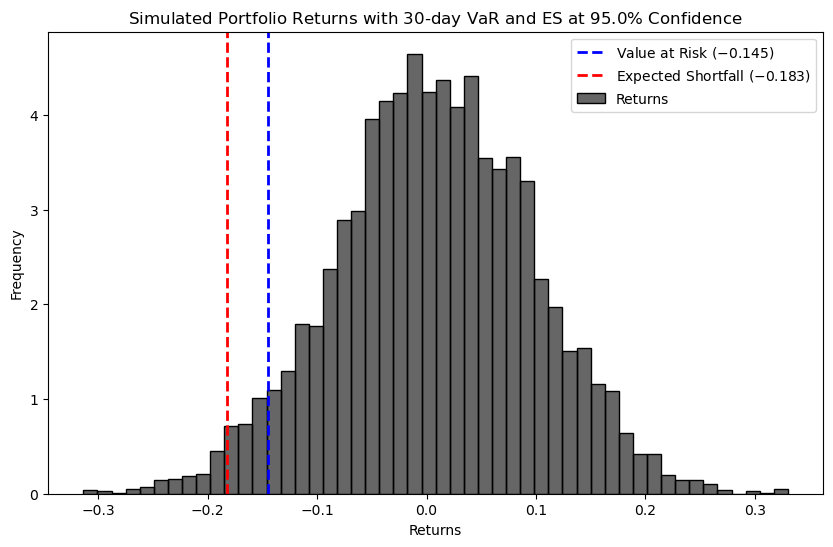

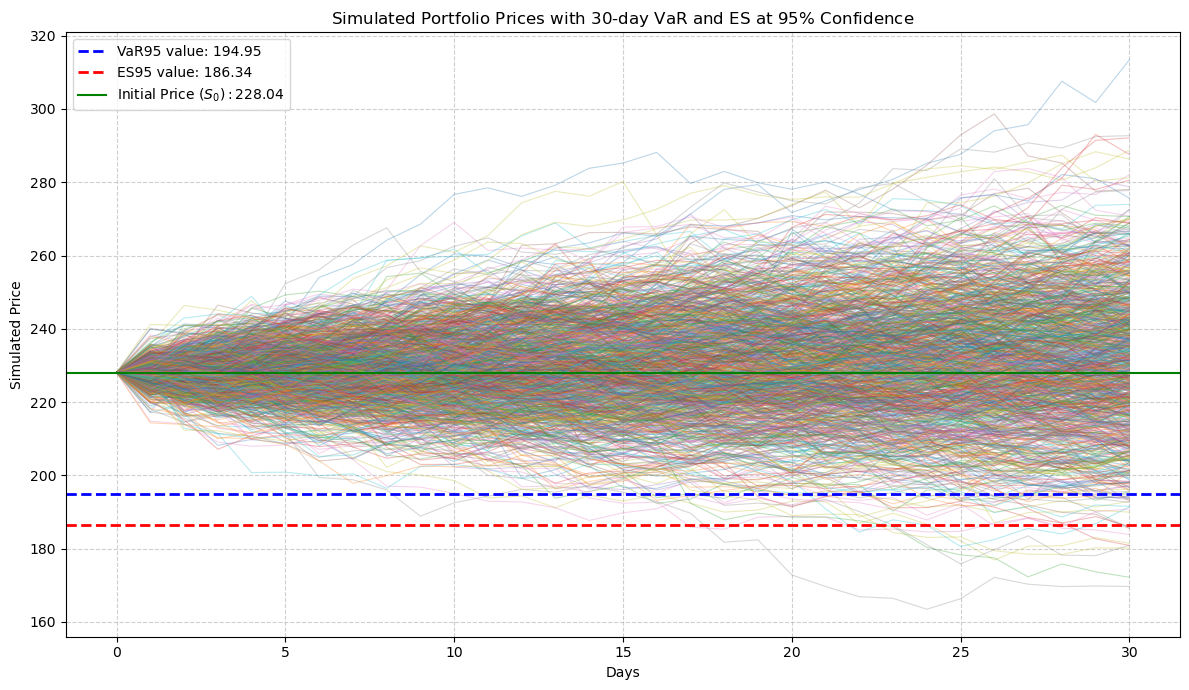

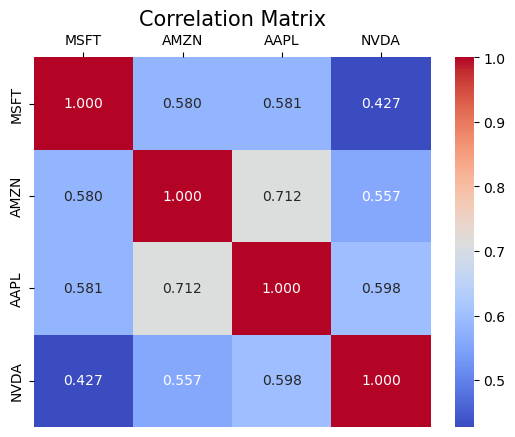

In [8]:
VaR, ES = VaR_ES(sim_returns, confidence_level)
print(f"{"\033[1m"}VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*VaR:.3f}% {"\033[0m"}")
print(f"{"\033[1m"}ES at {confidence_level*100}%(Merton Jump-Diffusion): {100*ES:.3f}%{"\033[0m"}")
plot_returns(sim_returns,confidence_level,VaR,ES,n_days)
plot_paths(sim_paths, np.dot(S0i,weights), confidence_level, VaR, ES, n_days)
plot_corr_mat(C, tickers)

<h3>Stressed VaR and ES</h3>

We will now model the stock with parameters estimated from a time of severe financial distress, namely the 2008 crisis. That is, the stocks will be modelled based on their returns from $\bf{}01/09/2008$ to $\bf{}01/09/2009$ by repeating the procedure followed above.

In [9]:
"""Parameter Estimation"""

tickers = ["MSFT","AMZN","AAPL","NVDA"]     #choose portfolio of stocks
Δt = 1/252
t1 = '2008-09-01' 
t2 = '2009-09-01'

stress_params = {}
s_S0 = {} 
s_data = {}
for ticker in tickers:
    s_data = yf.download(ticker, t1, t2, progress=False)
    s_prices = s_data['Close']
    s_log_returns = np.log(s_prices / s_prices.shift(1)).dropna()
    s_log_returns = s_log_returns[ticker].to_numpy()
    s_Model = JD_Param_Est(s_log_returns, Δt, pdf_type="normal")
    stress_params[ticker] = s_Model.estimate_parameters()

s_tuples = list(zip(*stress_params.values()))
s_params = np.array([tup for tup in s_tuples])


Parameter estimation in progress...
Optimization finished in 0.99 seconds.

Parameter estimation in progress...
Optimization finished in 0.42 seconds.

Parameter estimation in progress...
Optimization finished in 1.23 seconds.

Parameter estimation in progress...
Optimization finished in 0.48 seconds.


In [10]:
"""Monte Carlo"""

#construct portfolio returns
weights = np.array([1/len(tickers) for i in range(len(tickers))])     #define weights
s_Data = yf.download(tickers, t1, t2)                                 #download data
s_close_prices = s_Data["Close"]
s_S0i = s_close_prices.iloc[0].to_numpy()                             #initial stock prices
s_returns = np.log(s_close_prices / s_close_prices.shift(1)).dropna()
s_portfolio_returns = np.dot(s_returns,weights)                       #portfolio of weighted stocks
s_C = s_returns.corr().values                                         #correlation matrix

#perform Monte Carlo simulations
n_runs = 100000                                     #number of Monte Carlo runs
n_days = 30                                         #time horizon
confidence_level = 0.95                             #set confidence level for VaR
s_MC = Monte_Carlo(s_C,s_params,S0i,Δt,n_runs,n_days)
s_sim_returns , s_sim_paths = s_MC.collect_returns()
s_sim_returns = np.dot(s_sim_returns,weights.T)
s_sim_paths = np.dot(s_sim_paths,weights.T)

[*********************100%***********************]  4 of 4 completed


VaR at 95.0%(Merton Jump-Diffusion): -28.698% 
ES at 95.0%(Merton Jump-Diffusion): -36.130%


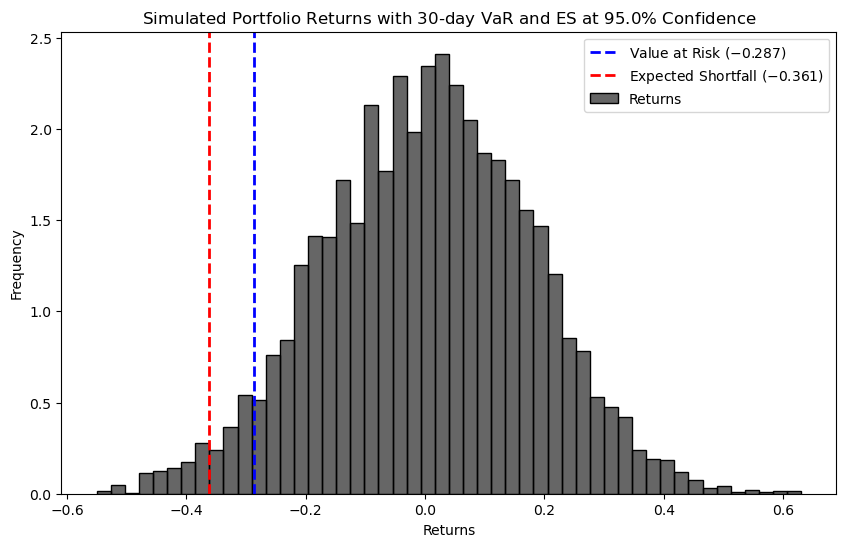

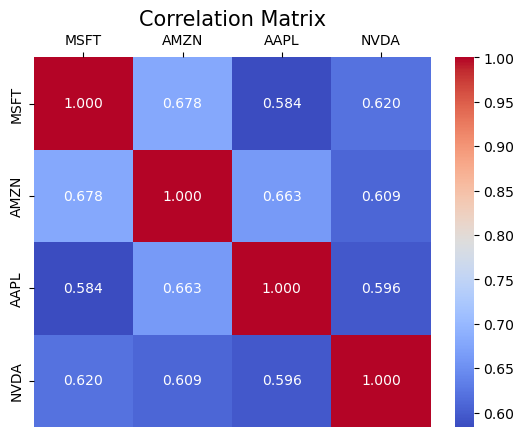

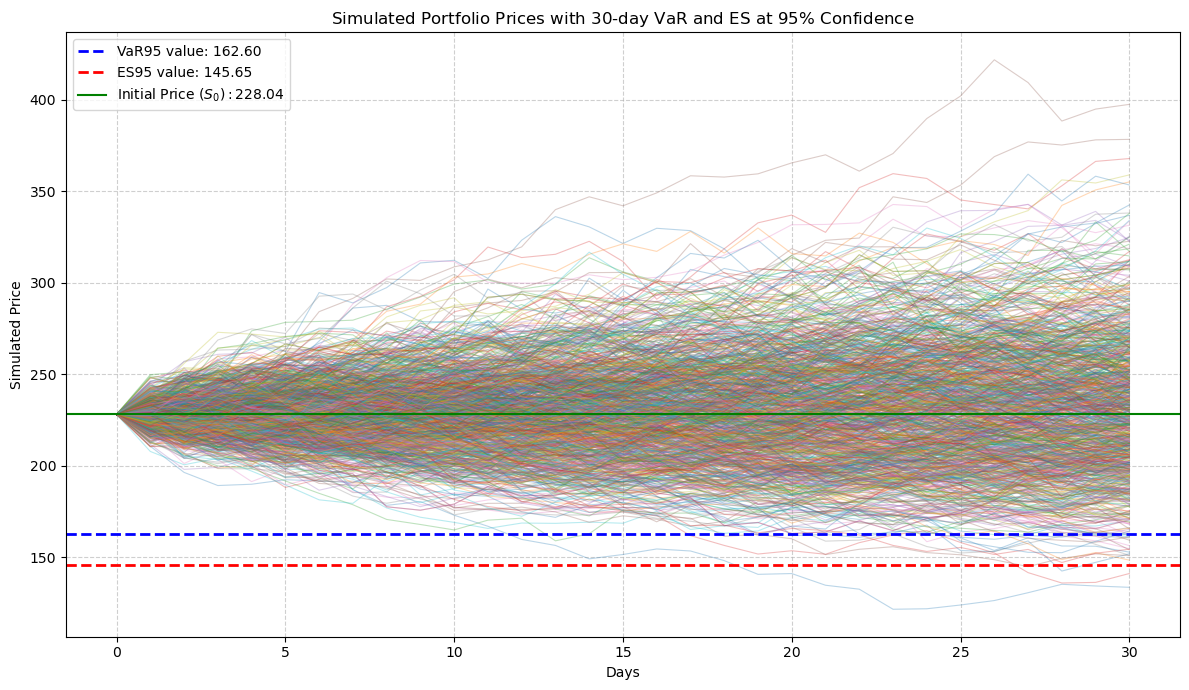

In [11]:
"""Stressed VaR and ES"""

s_VaR, s_ES = VaR_ES(s_sim_returns, confidence_level)
print(f"{"\033[1m"}VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*s_VaR:.3f}% {"\033[0m"}")
print(f"{"\033[1m"}ES at {confidence_level*100}%(Merton Jump-Diffusion): {100*s_ES:.3f}%{"\033[0m"}")
plot_returns(s_sim_returns,confidence_level,s_VaR,s_ES,n_days)
plot_corr_mat(s_C, tickers)
plot_paths(s_sim_paths, np.dot(S0i,weights), confidence_level, s_VaR, s_ES, n_days)

The VaR and ES are roughly twice as worse as before. However, considering the results from the previous notebook, where we considered stocks from the 1990s and observed a tripling of losses, our results here show that the market over the past 12 months(May 2025 - May 2024) has gotten much more volatile. 

## References

<a id="ref1"></a>[1] Burgess, Nicholas, "<a href="https://ssrn.com/abstract=4066115">*Correlated Monte Carlo Simulation using Cholesky Decomposition*</a>" (March 25, 2022). Available at SSRN: https://ssrn.com/abstract=4066115

<a id="ref2"></a>[2] Martin, M. "<a href="https://ora.ox.ac.uk/objects/uuid:a169f320-4ef9-49a0-9297-1cf0bc4dce23">*A Two-Asset Jump Diffusion
Model with Correlation*</a>"(Thesis) 2007.